## INFO DASHBOARD

En este documento se encuentran los gráficos que se van a mostrar en el Dashboard final. Estos gráficos mostrarán información extra sobre los alojamientos de Airbnb de NY:
   * Pie chart con tipos de casa
   * Distribucion de precios (apilado barrios) - dinamico
   * Wordcloud features más repetidas
   * Response time y superhosts
   * Tabla: accomodates, beds, bathrooms
   * Occupancy rate (mapa o grafico??)
   * Tabla hosts top10 → % de casas sobre total NY

Todos estos datos serán actualizados con los siguientes filtros que se insertarán en el dashboard final (Dash)
  1. Tipo de casa
  2. Barrio grande o todo NY
  3. Slider con rango de precios
  4. Nota de reseña

#### Librerías

In [21]:
import numpy as np
from sklearn.decomposition import PCA
from urllib.parse import urlencode
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots


pio.renderers.default = 'vscode'
pio.templates.default = 'plotly'

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize


import plotly.figure_factory as ff

import geopandas 
import json

from cv2 import mean
from itertools import count

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#### Importación de datos

In [22]:
listings_total_data = pd.read_parquet("../../Data/total data/raw data parquet/listings.parquet")
pd.options.display.max_columns = None
listings_total_data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20220907064715,2022-09-07,city scrape,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/3949d073-a02e...,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/86745...,https://a0.muscache.com/im/pictures/user/86745...,Gravesend,9.0,12.0,"['email', 'phone']",t,t,"Brooklyn , New York, United States",Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",$299.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,2022-09-07,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.00,4.75,4.88,None,f,9,1,6,2,0.11
1,2595,https://www.airbnb.com/rooms/2595,20220907064715,2022-09-07,city scrape,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, NY",A New Yorker since (Phone number hidden by Air...,within a day,75%,23%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,9.0,"['email', 'phone', 'work_email']",t,t,"New York, United States",Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Stove"", ""Coffee maker"", ""Long term stays all...",$175.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,5,280,2022-09-07,49,1,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.80,4.81,4.40,None,f,3,3,0,0,0.31
2,5121,https://www.airbnb.com/rooms/5121,20220907064715,2022-09-07,city scrape,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,None,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, NY","I am an artist(painter, filmmaker) and curato...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,2.0,2.0,"['email', 'phone']",t,t,None,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,None,1.0,1.0,"[""Heating"", ""Kitchen"", ""Air conditioning"", ""Wi...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,5,30,60,335,2022-09-07,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,None,f,2,0,2,0,0.31
3,45910,https://ww

In [23]:
#selección de las columnas que nos interesan
columnList = ["id","last_scraped","host_since","host_response_time","host_id","host_response_rate","host_acceptance_rate",
              "host_is_superhost","host_neighbourhood","host_listings_count","host_total_listings_count","host_has_profile_pic",
              "host_identity_verified","neighbourhood_cleansed","neighbourhood_group_cleansed","latitude","longitude","property_type",
              "room_type","accommodates","bathrooms","bathrooms_text","bedrooms","beds","amenities","price","minimum_nights","maximum_nights",
              "minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm",
              "calendar_updated","has_availability","availability_30","availability_60","availability_90","availability_365","number_of_reviews","number_of_reviews_ltm",
              "number_of_reviews_l30d","first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
              "review_scores_communication","review_scores_location","review_scores_value","license","instant_bookable","calculated_host_listings_count","calculated_host_listings_count_entire_homes",
              "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms","reviews_per_month"]


listings_reduced_df = listings_total_data[[x for x in listings_total_data.columns if x in columnList]]
listings_reduced_df["price"] = listings_reduced_df["price"].str.replace(pat=",",repl="")
listings_reduced_df["price"] = listings_reduced_df["price"].str.replace(pat="$",repl="")
listings_reduced_df["price"]=listings_reduced_df["price"].astype(float)
listings_reduced_df.head()

c:\Users\belen\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,2022-09-07,2787,2008-09-07,within an hour,100%,90%,f,Gravesend,9.0,12.0,t,t,Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",299.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.00,4.75,4.88,None,f,9,1,6,2,0.11
1,2595,2022-09-07,2845,2008-09-09,within a day,75%,23%,f,Midtown,6.0,9.0,t,t,Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Stove"", ""Coffee maker"", ""Long term stays all...",175.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,5,280,49,1,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.80,4.81,4.40,None,f,3,3,0,0,0.31
2,5121,2022-09-07,7356,2009-02-03,within an hour,100%,100%,t,Bedford-Stuyvesant,2.0,2.0,t,t,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,None,1.0,1.0,"[""Heating"", ""Kitchen"", ""Air conditioning"", ""Wi...",60.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,5,30,60,335,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,None,f,2,0,2,0,0.31
3,45910,2022-09-07,204539,2010-08-17,within an hour,100%,19%,f,Ridgewood,7.0,7.0,t,t,Ridgewood,Queens,40.70309,-73.89963,Entire townhouse,Entire home/apt,16,NaN,2.5 baths,5.0,10.0,"[""Hair dryer"", ""Essentials"", ""Carbon monoxide ...",425.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,30,60,90,365,13,0,0,2012-01-03,2019-11-12,4.42,4.64,4.36,4.82,5.00,4.82,4.55,None,f,6,6,0,0,0.10
4,5136,2022-09-07,7378,2009-02-03,None,None,33%,f,Greenwood Heights,1.0,5.0,t,t,Sunset Park,Brooklyn,40.66265,-73.99454,Entire rental unit,Entire home/apt,4,NaN,1.5 baths,2.0,2.0,"[""Hair dryer"", ""Cable TV"", ""Refrigerator"", ""BB...",275.0,21,1125,21.0,21.0,1125.0,1125.0,21.0,1125.0,NaN,t,0,0,0,179,3,1,1,2014-01-02,2022-08-10,5.00,5.00,5.00,5.00,5.00,4.67,5.00,None,f,1,1,0,0,0.03


In [24]:
# reemplazamos los "%" para obtener valores numericos de los ratios
listings_reduced_df["host_response_rate"] = listings_reduced_df["host_response_rate"].replace({'%':''}, regex=True)
listings_reduced_df["host_acceptance_rate"] = listings_reduced_df["host_acceptance_rate"].replace({'%':''}, regex=True)
listings_reduced_df.head(2)

,id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,2022-09-07,2787,2008-09-07,within an hour,100,90,f,Gravesend,9.0,12.0,t,t,Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",299.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.0,4.75,4.88,None,f,9,1,6,2,0.11
1,2595,2022-09-07,2845,2008-09-09,within a day,75,23,f,Midtown,6.0,9.0,t,t,Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Stove"", ""Coffee maker"", ""Long term stays all...",175.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,5,280,49,1,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.8,4.81,4.40,None,f,3,3,0,0,0.31


In [25]:
# sustituyo los NA por ceros
listings_reduced_df["host_response_rate"] = listings_reduced_df["host_response_rate"].replace(np.nan, 0)
listings_reduced_df["host_acceptance_rate"] = listings_reduced_df["host_acceptance_rate"].replace(np.nan, 0)

In [26]:
# paso la variable a int
listings_reduced_df["host_response_rate"] = listings_reduced_df["host_response_rate"].astype("int64")
listings_reduced_df["host_acceptance_rate"] = listings_reduced_df["host_acceptance_rate"].astype("int64")

In [27]:
# lectura de geoson distritos
geosonNeighbourhoods = geopandas.read_file("../../Data/neighbourhoods/neighbourhoods.geojson")
jsonGeoNeigh = json.load(open("../../Data/neighbourhoods/neighbourhoods.geojson"))
geosonNeighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ..."
1,Allerton,Bronx,"MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ..."
2,City Island,Bronx,"MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ..."
3,Ditmars Steinway,Queens,"MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ..."
4,Ozone Park,Queens,"MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ..."
...,...,...,...
228,Westchester Square,Bronx,"MULTIPOLYGON (((-73.84294 40.84640, -73.83913 ..."
229,Westerleigh,Staten Island,"MULTIPOLYGON (((-74.13131 40.62633, -74.13192 ..."
230,Williamsbridge,Bronx,"MULTIPOLYGON (((-73.86722 40.86969, -73.86701 ..."
231,Williamsburg,Brooklyn,"MULTIPOLYGON (((-73.95757 40.72510, -73.95300 ..."


In [28]:
# lectura de geoson barrios
bigJSONNeigh = json.load(open("../../Data/neighbourhoods/bigneighbourhoods.geojson"))
geosonNeighbourhoodsBig = geopandas.read_file("../../Data/neighbourhoods/bigneighbourhoods.geojson")
geosonNeighbourhoodsBig

,neighbourhood_group,geometry
0,Brooklyn,"POLYGON ((-73.98202 40.57139, -73.98199 40.571..."
1,Bronx,"MULTIPOLYGON (((-73.89015 40.80496, -73.88937 ..."
2,Staten Island,"POLYGON ((-74.21338 40.50677, -74.21353 40.506..."
3,Queens,"MULTIPOLYGON (((-73.86269 40.56650, -73.86270 ..."
4,Manhattan,"MULTIPOLYGON (((-73.99955 40.70769, -73.99961 ..."


   * Pie chart con tipos de casa


*Hemos considerado importante este gráfico para que el usuario pueda entender la proporción de cada tipo de casa que se oferta.*

In [29]:
# seleccion de valores mas recurrentes de tipo de propiedad (top5)
tipos = ["Entire rental unit", "Private room in rental unit", "Private room in home", "Entire condo", "Entire home"]
listing_type = listings_reduced_df[listings_reduced_df["property_type"].isin(tipos)]

In [30]:
level_count = pd.DataFrame(listing_type["property_type"].value_counts()).reset_index().rename(columns = {"index":"property_type", "property_type": "count"})
level_count = level_count.sort_values("property_type").reset_index(drop = True)

fig = px.pie(level_count, values="count", names="property_type", color = "property_type",
            color_discrete_sequence = px.colors.sequential.Pinkyl)
fig.show()

   * Distribucion de precios (apilado barrios) - dinamico


In [31]:
listings_reduced_df.head(1)

,id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,2022-09-07,2787,2008-09-07,within an hour,100,90,f,Gravesend,9.0,12.0,t,t,Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",299.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.0,5.0,5.0,4.75,4.88,None,f,9,1,6,2,0.11


In [32]:
# ploteamos histograma para ver la distribucion de la antiguedad de los hosts (entre 0-1k)
fig = px.histogram(listings_reduced_df[listings_reduced_df["price"]<1000], x="price",labels = {"price": "Price per night ($)"},
                   nbins = 30, title="Distribution of Airbnb prices") # Si agregamos histnorm='probability density' normalizamos el resultado

fig.update_traces(marker_color = "darksalmon")
# Agregar espacios entre barras
fig.update_layout(bargap = 0.1)
fig.show()

In [55]:
# distribucion de precios (histograma) apilado por barrios

data = [
    go.Histogram(
        x = listings_reduced_df[(listings_reduced_df["price"]<1000) & (listings_reduced_df["price"]>=10) & (listings_reduced_df["neighbourhood_group_cleansed"] == "Brooklyn")]['price'],
        marker_color = "sandybrown",
        xbins=dict(
            start= 0,
            end= 600,
            size=5
        ),
        opacity=0.5,
        name = "Brooklyn"
    ),
    go.Histogram(
        x = listings_reduced_df[(listings_reduced_df["price"]<1000) & (listings_reduced_df["price"]>=10) & (listings_reduced_df["neighbourhood_group_cleansed"] == "Bronx")]['price'],
        marker_color = "tomato",
        xbins=dict(
            start= 0,
            end= 600,
            size=5
        ),
        opacity=0.5,
        name = "Bronx"
    ),
    go.Histogram(
        x = listings_reduced_df[(listings_reduced_df["price"]<1000) & (listings_reduced_df["price"]>=10) & (listings_reduced_df["neighbourhood_group_cleansed"] == "Staten Island")]['price'],
        marker_color = "saddlebrown",
        xbins=dict(
            start= 0,
            end= 600,
            size=5
        ),
        opacity=0.5,
        name = "Staten Island"
    ),
    go.Histogram(
        x = listings_reduced_df[(listings_reduced_df["price"]<1000) & (listings_reduced_df["price"]>=10) & (listings_reduced_df["neighbourhood_group_cleansed"] == "Queens")]['price'],
        marker_color = "red",
        xbins=dict(
            start= 0,
            end= 600,
            size=5
        ),
        opacity=0.5,
        name = "Queens"
    ),
    go.Histogram(
        x = listings_reduced_df[(listings_reduced_df["price"]<1000) & (listings_reduced_df["price"]>=10) & (listings_reduced_df["neighbourhood_group_cleansed"] == "Manhattan")]['price'],
        marker_color = "darkred",
        xbins=dict(
            start= 0,
            end= 600,
            size=5
        ),
        opacity=0.5,
        name = "Manhattan"
    )
]

layout = go.Layout(title = "Distribución de los precios por barrios", xaxis_title = "Precios por noche", yaxis_title = "Frecuencia",
                   barmode = "overlay", bargap = 0.1)

fig = go.Figure(data = data, layout = layout)

fig.show()

   * Wordcloud features más repetidas


In [88]:
amenities = []

for i in listings_reduced_df["amenities"]:
    i = i.split(",")
    for j in i:
        amenities.append(j)

cambios = ['[', ']', '"']
amenities_new = []
for i in amenities:
    for char in i:
        if char in cambios:
            new = i.replace(char,'')
    amenities_new.append(new)

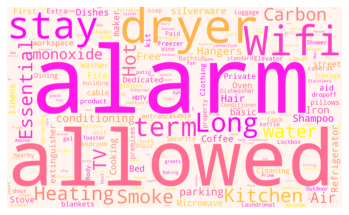

In [89]:
# Generacion de la imagen wordcloud

# creo la variable de texto
text = " ".join(cat for cat in amenities_new)

wordcloud = WordCloud(
        width=5000,
        height=3000,
        random_state=1,
        background_color="seashell",
        colormap="spring",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

   * Response time y superhosts

In [58]:
colors = {
    "t": ["gold","Superhost"],
    "f": ["lightgray", "Not Superhost"]
}

fig = go.Figure()
level_count = pd.DataFrame(listings_reduced_df.groupby("host_response_time")["host_is_superhost"].value_counts()).rename(columns = {"host_is_superhost": "count"}).reset_index()
group_count = pd.DataFrame(level_count.groupby(["host_response_time"])["count"].sum()).reset_index()
level_count=level_count.merge(group_count, on='host_response_time', how='left').rename(columns = {"count_x": "count","count_y": "total"})
level_count

# ordenar valores para que los segmentos aparezcan en orden
def sortfunc(seg):
  if seg in ("within an hour", "within a few hours"):
    return "00"+seg
  elif seg in ("within a day"):
    return "0"+seg
  else:
    return seg

level_count = level_count.sort_values(by="host_response_time", key=lambda x: x.apply(sortfunc))

for key in colors.keys():
    aux = level_count[level_count["host_is_superhost"] == key]
    fig.add_trace(
        go.Bar(
            x = aux["host_response_time"],
            y = 100*aux["count"]/aux["total"],
            name = colors[key][1],
            marker_color = colors[key][0],
            width= np.repeat(0.65,len(level_count))
        )
    )
    
fig.update_layout(title = "Distribution of superhosts grouped by time response, in relative numbers",
                  xaxis_title = "Time response", yaxis_title = "Relative number of hosts (%)", 
                  barmode='stack')

fig.show()


   * Tabla: accomodates, beds, bathrooms


In [ ]:
pip install fastnumbers

In [91]:
from fastnumbers import isfloat

baths = []

for i in listings_reduced_df["bathrooms_text"]:
    if type(i) == str:
        i = i.split(" ",1)
        if isfloat(i[0]):
            baths.append(float(i[0]))
        else:
            baths.append(0)
    else:
        baths.append(0)

In [92]:
# añado los baños procesados 
listings_reduced_df["baths"] = baths

In [125]:
neighbourhood_df = listings_reduced_df.groupby(['neighbourhood_group_cleansed', 'neighbourhood_cleansed']).aggregate({'id':'nunique','host_id':'nunique','accommodates':'mean','beds':'mean','baths':'mean'}).round(1)
neighbourhood_df

id  host_id  \
neighbourhood_group_cleansed neighbourhood_cleansed                
Bronx                        Allerton                45       35   
                             Baychester              29       20   
                             Belmont                 30       20   
                             Bronx Park              10        6   
                             Bronxdale               19       18   
...                                                  ..      ...   
Staten Island                Tottenville              8        6   
                             West Brighton           27       16   
                             Westerleigh              1        1   
                             Willowbrook              1        1   
                             Woodrow                  1        1   

                                                     accommodates  beds  baths  
neighbourhood_group_cleansed neighbourhood_cleansed                             
Bronx                        Allerton                         3.8   1.9    1.2  
                             Baychester                       3.1   1.6    1.0  
                             Belmont                          2.7   1.6    1.1  
                             Bronx Park                       5.2   2.5    1.3  
                             Bronxdale                        2.5   1.2    1.0  
...                                                           ...   ...    ...  
Staten Island                Tottenville                      3.9   1.8    1.6  
                             West Brighton                    2.3   1.7    1.0  
                             Westerleigh                      4.0   2.0    1.0  
                             Willowbrook                      8.0   6.0    2.5  
                             Woodrow                          2.0   1.0    1.0  

[244 rows x 5 columns]

*!!!!!!!!!!! La tabla pivote está hecha pero faltaría hacer un gráfico de tabla en sí*

   * Occupancy rate (mapa o grafico??)


In [100]:
listings_reduced_df.head(2)

,id,last_scraped,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,baths
0,2539,2022-09-07,2787,2008-09-07,within an hour,100,90,f,Gravesend,9.0,12.0,t,t,Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",299.0,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.0,4.75,4.88,None,f,9,1,6,2,0.11,1.0
1,2595,2022-09-07,2845,2008-09-09,within a day,75,23,f,Midtown,6.0,9.0,t,t,Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Stove"", ""Coffee maker"", ""Long term stays all...",175.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,5,280,49,1,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.8,4.81,4.40,None,f,3,3,0,0,0.31,1.0


In [104]:
# occupancy = ((reviews per month * min. nights) * 12) / availability_365

listings_reduced_df["occupancy_rate"] = (listings_reduced_df["reviews_per_month"]*12) / listings_reduced_df["availability_365"] 
listings_reduced_df["occupancy_rate"] = listings_reduced_df["occupancy_rate"]*100
listings_reduced_df["occupancy_rate"]

# NO TIENE NINGUN SENTIDO ESTE VALOR

0        0.370787
1        1.328571
2        1.110448
3        0.328767
4        0.201117
           ...   
39876         inf
39877         inf
39878    3.260870
39879         NaN
39880         inf
Name: occupancy_rate, Length: 39881, dtype: float64

   * Tabla hosts top10 → % de casas sobre total NY

In [127]:
# TOP 10 HOSTS CON EL MAYOR NÚMERO DE AIRBNB EN NY
hosts_df = listings_total_data.groupby(['host_id', 'host_name']).aggregate({'id':'nunique', 'review_scores_rating':'mean'}).round(1).reset_index()
hosts_df.sort_values(by='id', ascending=False).head(10)

,host_id,host_name,id,review_scores_rating
17371,107434423,Blueground,453,4.5
3128,3223938,Eugene,288,4.9
19196,158969505,Untitled,200,4.9
8943,19303369,Hiroki,175,3.9
20245,200239515,Shogo,158,4.1
20339,204704622,Momoyo,157,3.9
9744,22541573,Ken,131,4.5
14964,61391963,Stay With Vibe,116,4.7
18451,137358866,Kaz,111,4.8
14173,51501835,Jeniffer,109,4.6


In [132]:
# TOP 10 HOSTS CON EL MAYOR REVIEW SCORE DE AIRBNB EN NY
hosts_df.sort_values(by=['review_scores_rating','id'], ascending=False).head(10)

,host_id,host_name,id,review_scores_rating
24000,384532776,Nathan,44,5.0
24620,415840703,Anyplace,15,5.0
21289,243288727,Matt,14,5.0
8930,19243808,Nice Stay,12,5.0
24075,388603242,Hotel And The City,12,5.0
24418,404940500,Rove,12,5.0
12697,40523974,Yael,10,5.0
24310,399865453,Fenix,10,5.0
10931,28260018,Ivan,9,5.0
11125,29582882,Jerry & Lynn,9,5.0


In [134]:
# calculo todas las casas diferentes que hay en NY en Airbnb
total_houses_NY = listings_total_data['id'].nunique()
total_houses_NY

39881

In [139]:
# creo la variable que representa el % de casas que tiene el host 
hosts_df["house_percentage"] = hosts_df['id']/total_houses_NY*100
hosts_df.sort_values(by='house_percentage', ascending=False).head(10)

,host_id,host_name,id,review_scores_rating,house_percentage
17371,107434423,Blueground,453,4.5,1.135879
3128,3223938,Eugene,288,4.9,0.722148
19196,158969505,Untitled,200,4.9,0.501492
8943,19303369,Hiroki,175,3.9,0.438805
20245,200239515,Shogo,158,4.1,0.396179
20339,204704622,Momoyo,157,3.9,0.393671
9744,22541573,Ken,131,4.5,0.328477
14964,61391963,Stay With Vibe,116,4.7,0.290865
18451,137358866,Kaz,111,4.8,0.278328
14173,51501835,Jeniffer,109,4.6,0.273313
